In [1]:
import pandas as pd
import numpy as np

# visual
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2


from sklearn.feature_extraction.text import CountVectorizer


# Exploratory Data Analysis/ Feature Engineering

In [2]:
#Read json data for TheOnion and WorldNews subreddit into dataframes
onion_df = pd.read_json('./data/onion_posts.json')
news_df = pd.read_json('./data/news_posts.json')

In [3]:
#Combine news_df and onion_df into new DataFrame
df = pd.concat([onion_df, news_df], axis = 0)

In [4]:
df.head()

,subreddit,title
0,TheOnion,CDC Announces It Kind Of Embarrassing To Get C...
1,TheOnion,Minnesota Activists Showered In Celebratory Te...
2,TheOnion,Depressed Police Officer Reminds Self That Cha...
3,TheOnion,"‘This Is Strike One, Mr. Chauvin,’ Says Judge ..."
4,TheOnion,Jimmy Carter Shaken To See Friend Walter Monda...


In [5]:
#Shuffle rows in new data frame
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,subreddit,title
0,worldnews,COVID-19: India sees record case numbers as mi...
1,TheOnion,Wow: You Can Actually Just Press ‘L3’ To Talk ...
2,TheOnion,Ginsburg Clerks Wheel Filing Cabinets Into Cap...
3,TheOnion,Mental Health Experts Advise On Best Ways To C...
4,worldnews,Iran produces first batch of 60% enriched uranium


In [7]:
#Engineer feature to turn subreddit into a 1/0 column where 1 indicates onion
df['news'] = [1 if df.loc[i,'subreddit'] == 'worldnews' else 0 for i in range(df.shape[0])]

In [8]:
#Engineer feature for word count title
df['wordcount'] = df['title'].str.count(' ') + 1
onion_df['wordcount'] = onion_df['title'].str.count(' ') + 1
news_df['wordcount'] = news_df['title'].str.count(' ') + 1

In [9]:
#Engineer feature for character count in title
df['charcount'] = df['title'].str.len()
onion_df['charcount'] = onion_df['title'].str.len()
news_df['charcount'] = news_df['title'].str.len()

In [10]:
#Save df to json file
df.to_json(r'./data/combined_posts.json')

In [11]:
#check that dataframes are of simlar size
df['news'].value_counts()

0    2349
1    2229
Name: news, dtype: int64

## Finding top words in TheOnion subreddit titles

In [12]:
#Find the top words in onion_df
cvec = CountVectorizer(stop_words ='english')
cvec.fit(onion_df['title'])

len_features = len(cvec.get_feature_names())
print(len_features)

onion_df_cvec = pd.DataFrame(cvec.transform(onion_df['title']).todense(), columns = cvec.get_feature_names())

top_words_onion = onion_df_cvec.sum(axis = 0)

7769


In [13]:
#Get data frame for top words in onion titles
top_words_onion_df = top_words_onion.to_frame(name = 'count')
#create column for word by pulling from the index
top_words_onion_df['word'] = top_words_onion_df.index
top_words_onion_df.reset_index(drop=True,inplace = True)
#add a feature for frequency as a percentage for how often the word shows up in the whole column
top_words_onion_df['frequency'] = top_words_onion_df['count']/ len(top_words_onion_df) *100
#re-order columns
cols = ['word','count','frequency']
top_words_onion_df = top_words_onion_df[cols]
#sort columns by word count in descending order to get top 20 words
top_words_onion_df.sort_values(by = 'count', ascending = False, inplace = True)
top_words_onion_df.reset_index(drop = True,inplace = True)
top_words_onion_df.head(30)
top_words_onion_df.to_csv(r'./data/top_words_onion.csv')

In [32]:
top_words_onion_df.head(30)


,word,count,frequency
0,trump,187,2.407002
1,man,156,2.007980
2,new,150,1.930750
3,just,101,1.300039
4,onion,88,1.132707
5,biden,80,1.029734
6,says,77,0.991119
7,coronavirus,76,0.978247
8,nation,75,0.965375
9,like,70,0.901017


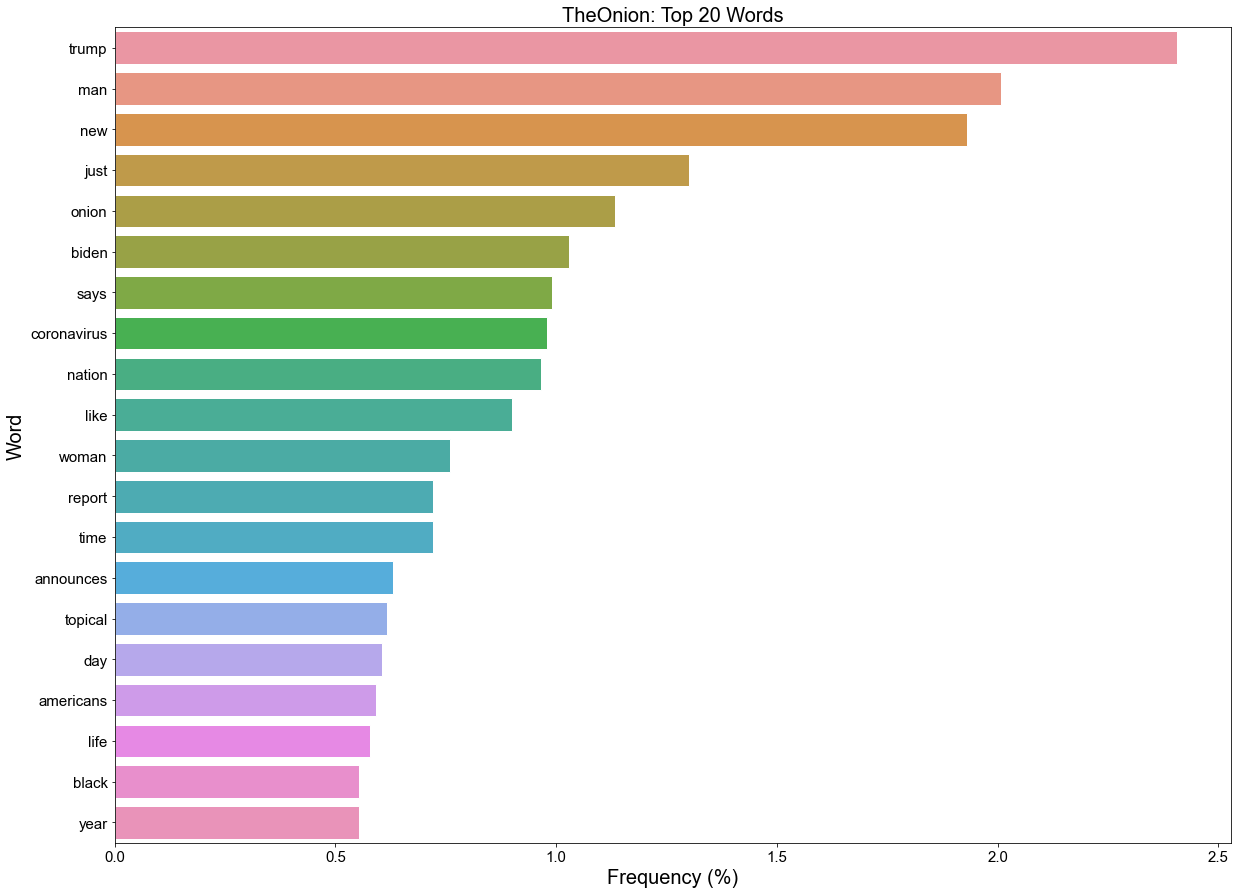

In [14]:
plt.figure(figsize=(20,15))
plt.title('TheOnion: Top 20 Words', fontsize = 20)

sns.set_style('whitegrid')
sns.barplot(data = top_words_onion_df.head(20), x ='frequency', y = 'word', orient = 'h')

plt.xlabel('Frequency (%)', fontsize = 20)
plt.ylabel('Word', fontsize = 20)
plt.tick_params(labelsize = 15)
plt.savefig('./data/oniontop20words')

Not surprising that the most common and frequently used words in TheOnion title headlines are related to significant current events from the past year. Especially considering that The Onion is a US based satirical digital media company.  

Thus, the election, black lives matter, coronavirus for example would be of interest for them to write about.  

It can also be seen that topical and onion are top words in this list. These words should be used as stop words later on when building the model later on to avoid bias in the matching process.

## Finding most common bigrams in TheOnion subreddit titles

In [15]:
#Find most common bigrams in onion_df
cv_bigrams = CountVectorizer(ngram_range = (2,2), stop_words = 'english')
cv_bigrams.fit(onion_df['title'])

len_features = len(cvec.get_feature_names())
print(len_features)

onion_bigrams_cv = cv_bigrams.transform(onion_df['title'])
onion_bigrams_df = pd.DataFrame(onion_bigrams_cv.todense(), columns = cv_bigrams.get_feature_names())

top_bigrams_onion = onion_bigrams_df.sum(axis = 0)

7769


In [16]:
#Get data frame for top bigram in onion titles
top_bigrams_onion_df = top_bigrams_onion.to_frame(name = 'count')
#create column for bigram by pulling from the index
top_bigrams_onion_df['bigram'] = top_bigrams_onion_df.index
top_bigrams_onion_df.reset_index(drop=True,inplace = True)
#add a feature for frequency as a percentage for how often the bigram shows up in the whole column
top_bigrams_onion_df['frequency'] = top_bigrams_onion_df['count']/ len(top_bigrams_onion_df) *100
#re-order columns
cols = ['bigram','count','frequency']
top_bigrams_onion_df = top_bigrams_onion_df[cols]
#sort columns by bigram count in descending order to get top 20 words
top_bigrams_onion_df.sort_values(by = 'count', ascending = False, inplace = True)
top_bigrams_onion_df.reset_index(drop = True,inplace = True)
top_bigrams_onion_df.head(30)
top_bigrams_onion_df.to_csv(r'./data/top_bigrams_onion.csv')

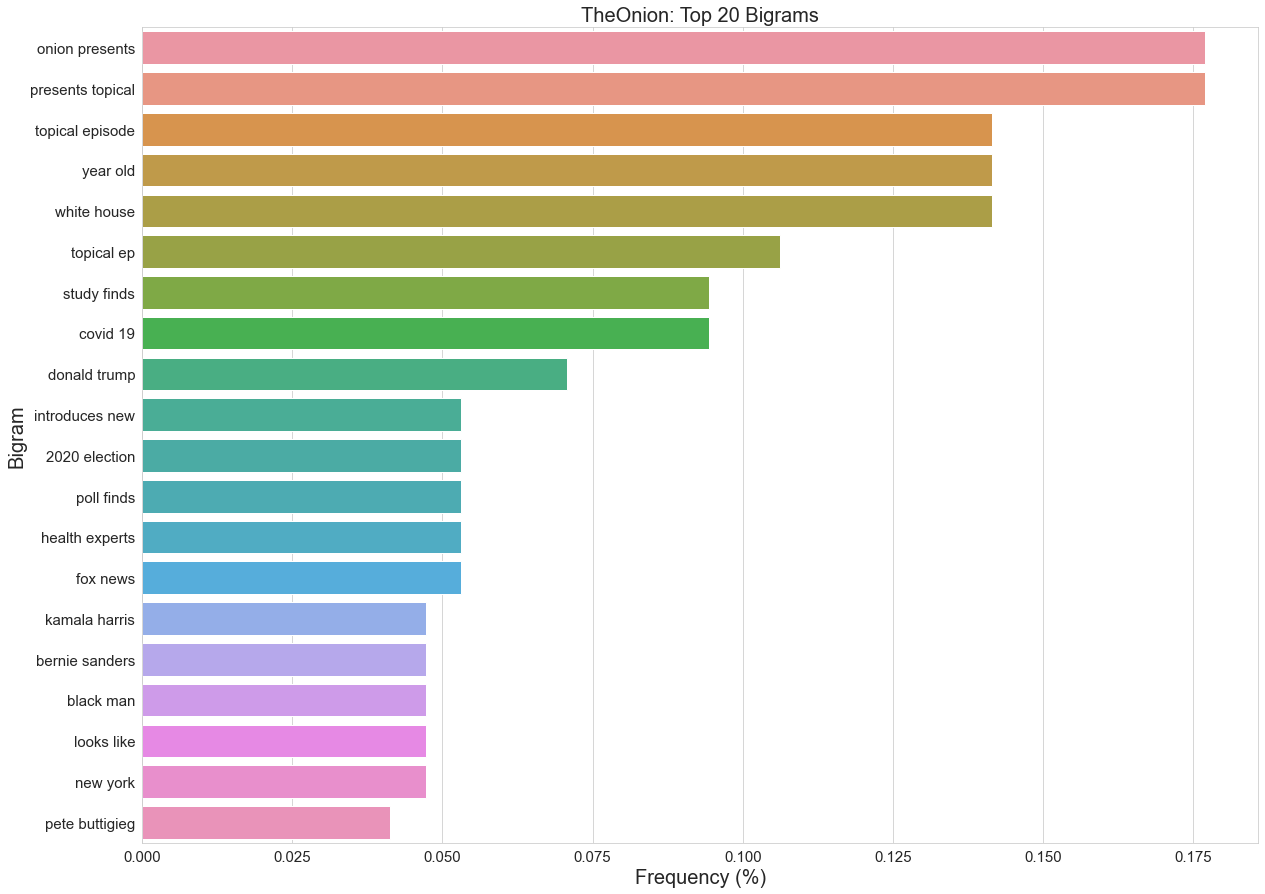

In [17]:
plt.figure(figsize=(20,15))
plt.title('TheOnion: Top 20 Bigrams', fontsize = 20)

sns.set_style('whitegrid')
sns.barplot(data = top_bigrams_onion_df.head(20), x ='frequency', y = 'bigram', orient = 'h')

plt.xlabel('Frequency (%)', fontsize = 20)
plt.ylabel('Bigram', fontsize = 20)
plt.tick_params(labelsize = 15)
plt.savefig('./data/oniontop20bigrams')

Similarly to the top bigrams for the titles of the subreddit are also mostly related to current events that have happened in the past year in the USA.

The bigrams onion presents and topical episode also show up many times in the top bigrams which could affect our model later on as we expected. Thus we must add a list of stopwords that includes these words to our CountVectorizer when the models are being built later on to prevent bias.

In [18]:
#Print the top words in new_df
cvec = CountVectorizer(stop_words ='english')
cvec.fit(news_df['title'])

len_features = len(cvec.get_feature_names())
print(len_features)

news_df_cvec = pd.DataFrame(cvec.transform(news_df['title']).todense(), columns = cvec.get_feature_names())

top_words_news = news_df_cvec.sum(axis = 0)

5734


In [19]:
#Get data frame for top words in world news titles
top_words_news_df = top_words_news.to_frame(name = 'count')
#create column for word by pulling from the index
top_words_news_df['word'] = top_words_news_df.index
top_words_news_df.reset_index(drop=True,inplace = True)
#add a feature for frequency as a percentage for how often the word shows up in the whole column
top_words_news_df['frequency'] = top_words_news_df['count']/ len(top_words_news_df) *100
#re-order columns
cols = ['word','count','frequency']
top_words_news_df = top_words_news_df[cols]
#sort columns by word count in descending order to get top 20 words
top_words_news_df.sort_values(by = 'count', ascending = False, inplace = True)
top_words_news_df.reset_index(drop = True,inplace = True)
top_words_news_df.head(30)
top_words_news_df.to_csv(r'./data/top_words_news.csv')

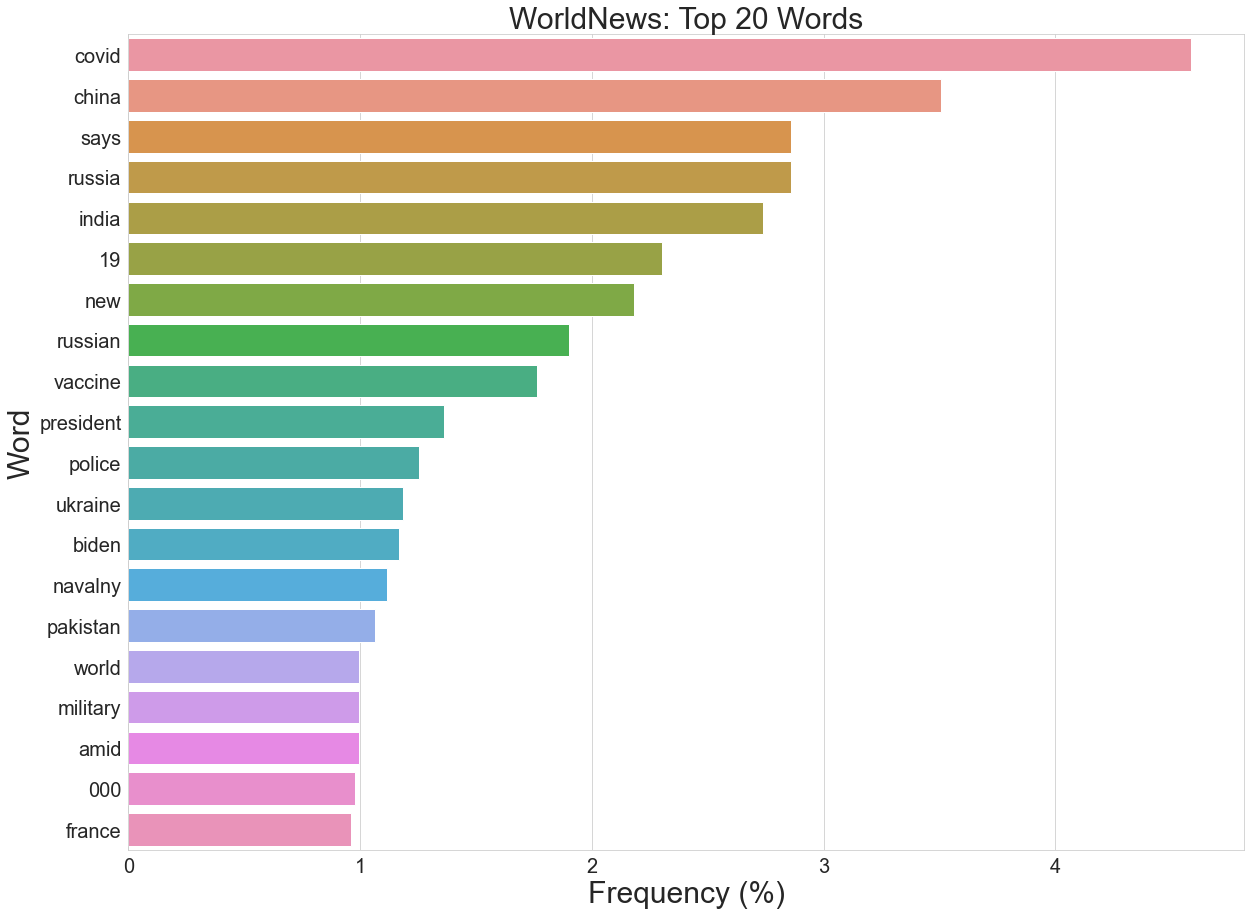

In [20]:
plt.figure(figsize=(20,15))
plt.title('WorldNews: Top 20 Words', fontsize = 30)

sns.set_style('whitegrid')
sns.barplot(data = top_words_news_df.head(20), x ='frequency', y = 'word', orient = 'h')

plt.xlabel('Frequency (%)', fontsize = 30)
plt.ylabel('Word', fontsize = 30)
plt.tick_params(labelsize = 20)
plt.savefig('./data/newstop20words')

Top words in the titles for the worldnews subreddit are also very much related to significant events that happened in the last year. A lot of them are related to COVID-19 and most recently the death of Prince Phillip. We may want to consider removing 000 and adding it to the stopword list as it is most likely a statistic in the form 'X,000'. Where X is any integer.

In [21]:
#Find most common bigrams in new_df
cv_bigrams = CountVectorizer(ngram_range = (2,2), stop_words = 'english')
cv_bigrams.fit(news_df['title'])

news_bigrams_cv = cv_bigrams.transform(news_df['title'])
news_bigrams_df = pd.DataFrame(news_bigrams_cv.todense(), columns = cv_bigrams.get_feature_names())

top_bigrams_news = news_bigrams_df.sum(axis = 0)

In [22]:
#Get data frame for top bigram in news titles
top_bigrams_news_df = top_bigrams_news.to_frame(name = 'count')
#create column for bigram by pulling from the index
top_bigrams_news_df['bigram'] = top_bigrams_news_df.index
top_bigrams_news_df.reset_index(drop=True,inplace = True)
#add a feature for frequency as a percentage for how often the bigram shows up in the whole column
top_bigrams_news_df['frequency'] = top_bigrams_news_df['count']/ len(top_bigrams_news_df) *100
#re-order columns
cols = ['bigram','count','frequency']
top_bigrams_news_df = top_bigrams_news_df[cols]
#sort columns by bigram count in descending order to get top 20 words
top_bigrams_news_df.sort_values(by = 'count', ascending = False, inplace = True)
top_bigrams_news_df.reset_index(drop = True,inplace = True)
top_bigrams_news_df.head(20)
top_bigrams_news_df.to_csv(r'./data/top_bigrams_news.csv')

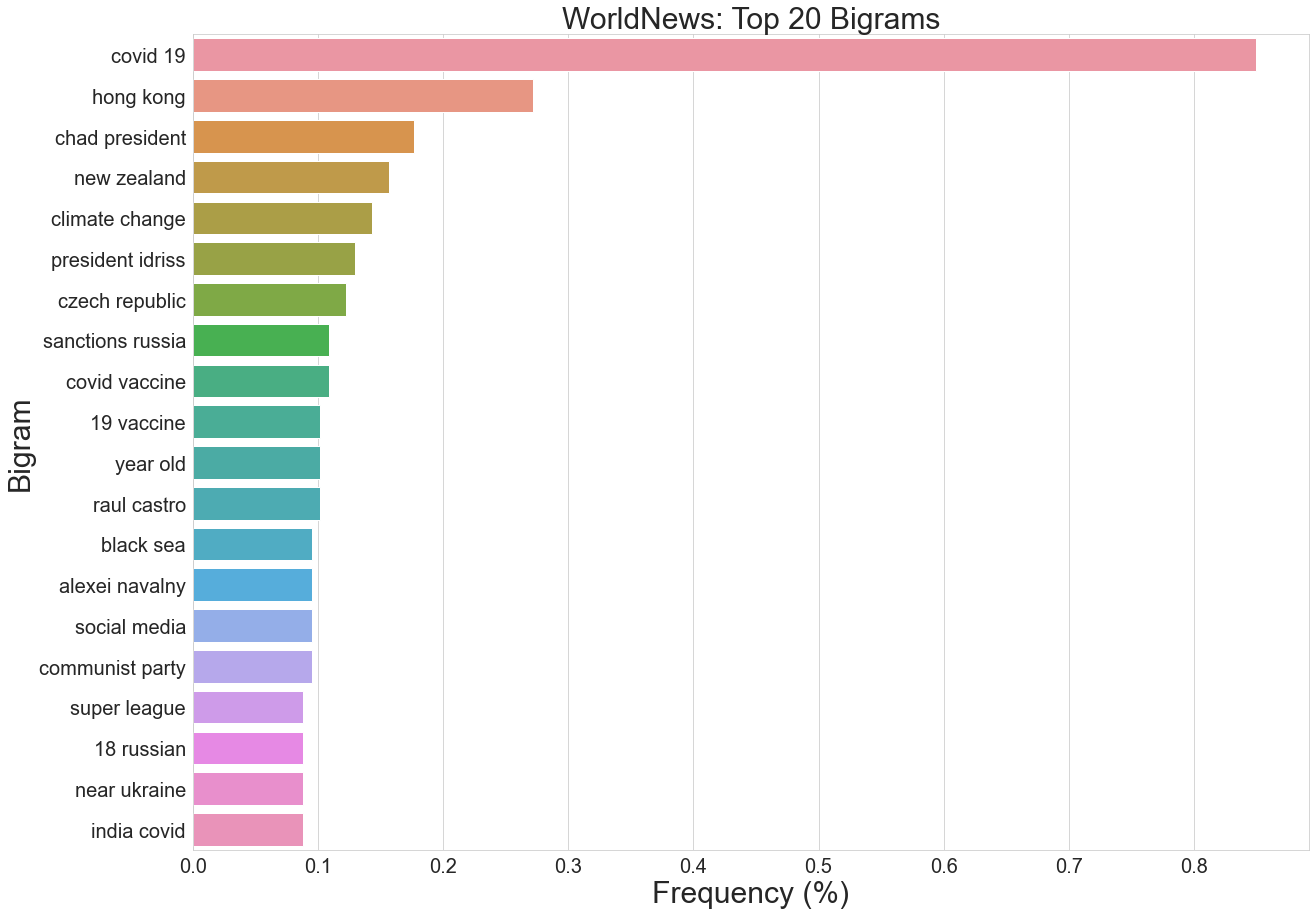

In [23]:
plt.figure(figsize=(20,15))
plt.title('WorldNews: Top 20 Bigrams', fontsize = 30)

sns.set_style('whitegrid')
sns.barplot(data = top_bigrams_news_df.head(20), x ='frequency', y = 'bigram', orient = 'h')

plt.xlabel('Frequency (%)', fontsize = 30)
plt.ylabel('Bigram', fontsize = 30)
plt.tick_params(labelsize = 20)
plt.savefig('./data/newstop20bigrams')

Similarly to the top words in the news, top bigrams are also heavily related to significant events that have happened in the past few months. Covid, the death of significant figure heads and climate change. These words are bound to change as we collect more data but also will change according to the time frame that they are taken from.

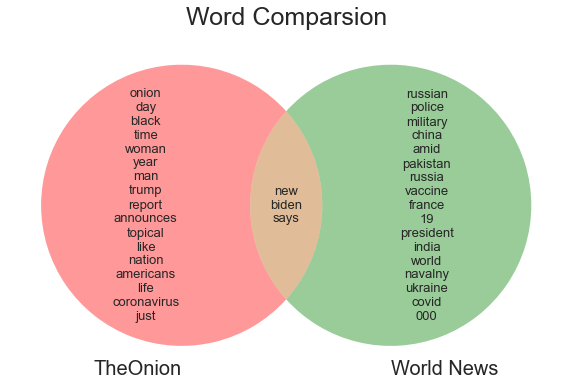

In [24]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(top_words_onion_df['word'][:20])
set_b = set(top_words_news_df['word'][:20])

venn = venn2([set_a,set_b],set_labels=['TheOnion','World News'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

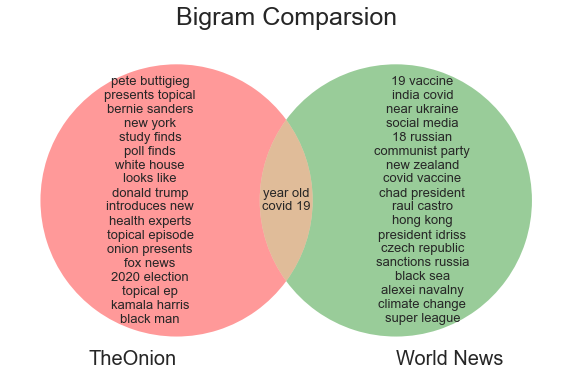

In [25]:
plt.figure(figsize=(10,10))
plt.title('Bigram Comparsion',fontsize=25)

set_a = set(top_bigrams_onion_df['bigram'][:20])
set_b = set(top_bigrams_news_df['bigram'][:20])

venn = venn2([set_a,set_b],set_labels=['TheOnion','World News'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

## Distribution of word count and character count of title

In [26]:
news_df.describe()

,wordcount,charcount
count,2229.000000,2229.000000
mean,12.906685,82.448183
std,7.003737,43.307692
min,1.000000,6.000000
25%,9.000000,60.000000
50%,11.000000,70.000000
75%,14.000000,87.000000
max,57.000000,304.000000


In [27]:
onion_df.describe()

,wordcount,charcount
count,2349.000000,2349.000000
mean,13.193699,82.090677
std,5.361738,31.028245
min,1.000000,1.000000
25%,10.000000,62.000000
50%,13.000000,82.000000
75%,16.000000,100.000000
max,50.000000,296.000000


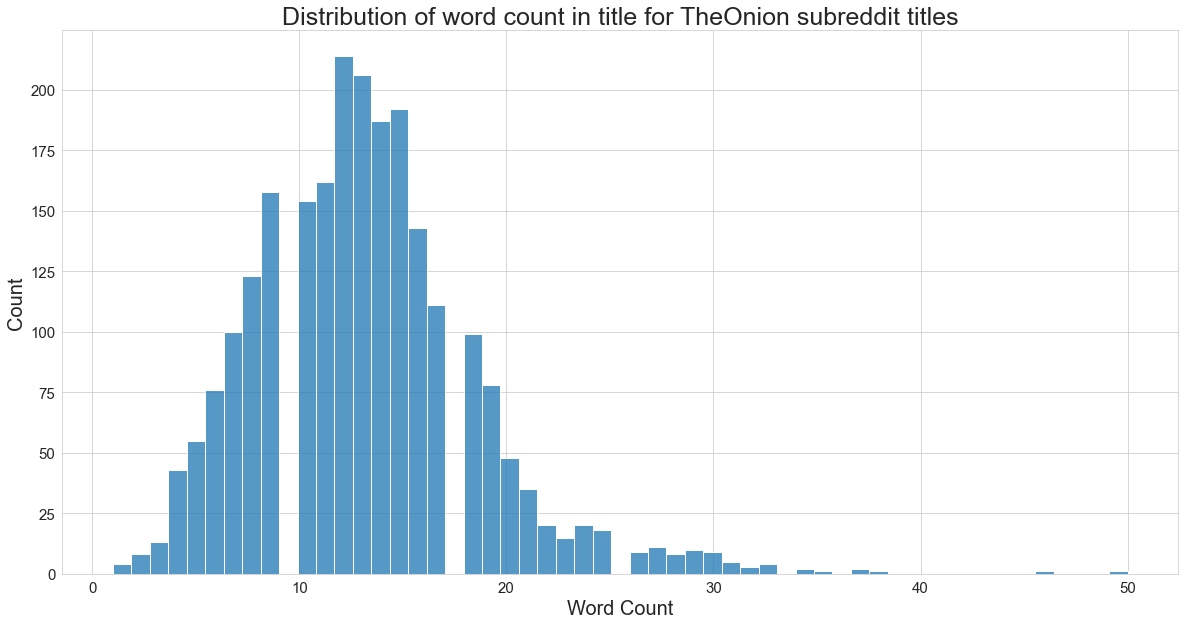

In [28]:
plt.figure(figsize=(20,10))
plt.title('Distribution of word count in title for TheOnion subreddit titles', fontsize = 25)

sns.set_style('whitegrid')
sns.histplot(data = onion_df, x ='wordcount')

plt.xlabel('Word Count', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(labelsize = 15)

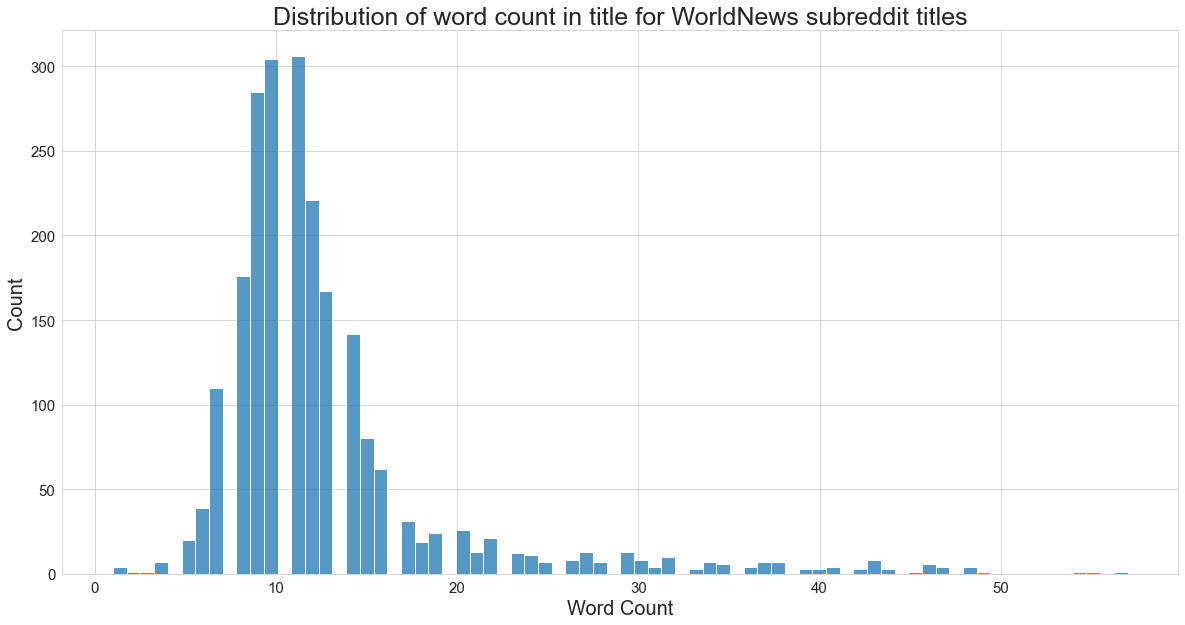

In [29]:
plt.figure(figsize=(20,10))
plt.title('Distribution of word count in title for WorldNews subreddit titles', fontsize = 25)

sns.set_style('whitegrid')
sns.histplot(data = news_df, x ='wordcount')

plt.xlabel('Word Count', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(labelsize = 15)

Titles in The Onion have a larger spread than titles in world news. However, the mean number of words seem to be about the same for the titles. The distribution of the data is skewed to the right but this can be fixed later on by transforming the data when models are built. Reason for the wider spread of data in The Onion titles vs. World News could be atrritbuted to the fact that The Onion is a satirical digital media company while articles in world news are all from official news outlets. Thus needing to hold a certain standard.

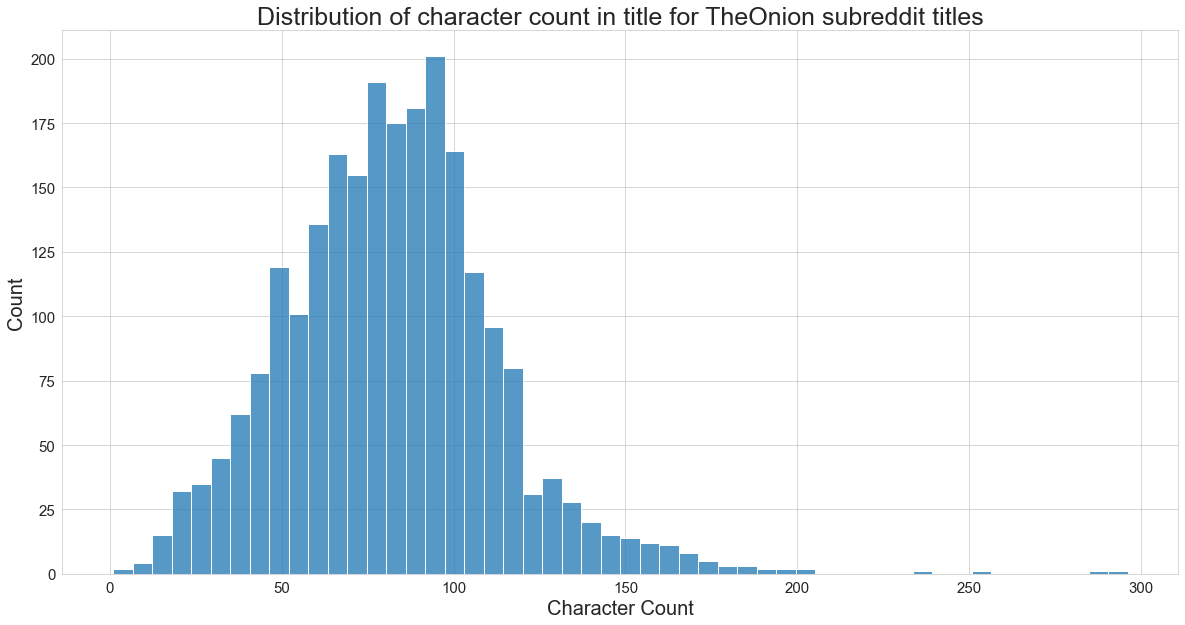

In [30]:
plt.figure(figsize=(20,10))
plt.title('Distribution of character count in title for TheOnion subreddit titles', fontsize = 25)

sns.set_style('whitegrid')
sns.histplot(data = onion_df, x ='charcount')

plt.xlabel('Character Count', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(labelsize = 15)

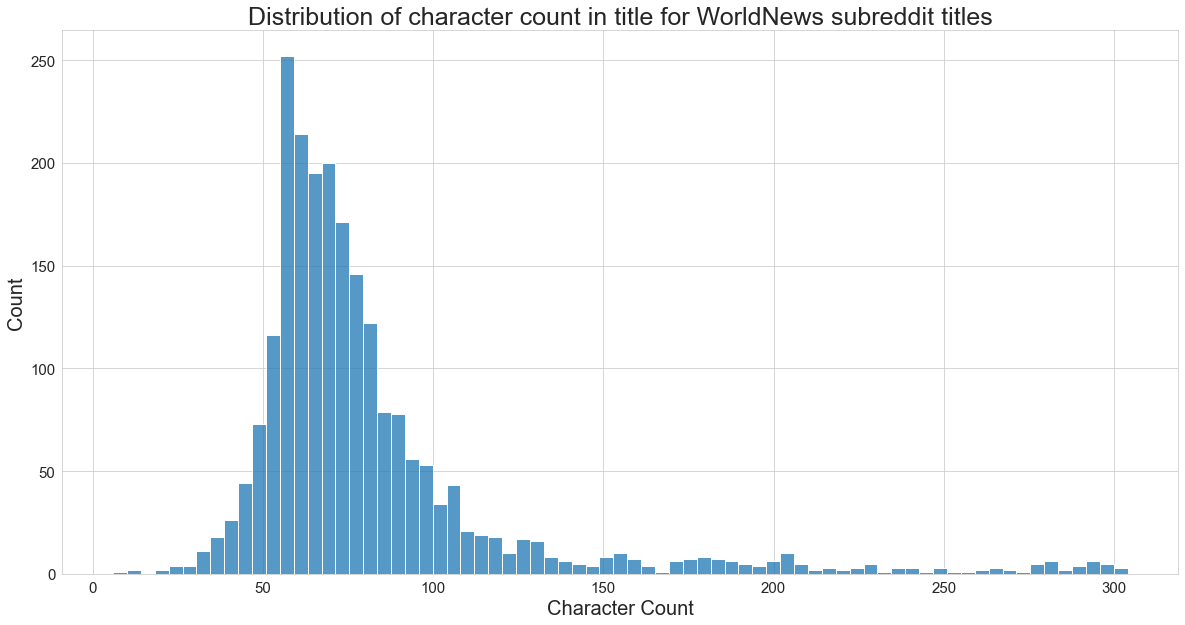

In [31]:
plt.figure(figsize=(20,10))
plt.title('Distribution of character count in title for WorldNews subreddit titles', fontsize = 25)

sns.set_style('whitegrid')
sns.histplot(data = news_df, x ='charcount')

plt.xlabel('Character Count', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(labelsize = 15)

The mean of the character count for both titles written in TheOnion and World News are also quite similar. The spread is slightly different with The Onion having a slightly larger spread again. This could again be due to the difference between satricial vs official news media. Both graphs are skewed to the right.